In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

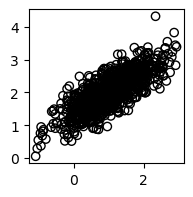

In [2]:
def get_samples(N = 1000):
    samples = np.random.multivariate_normal([1,2],[[0.5,0.3],[0.3,0.3]], size = (N,))
    return samples

samples = get_samples(1000)
plt.scatter(samples[:,0],samples[:,1], marker = 'o', facecolor = 'none', edgecolor = 'k')
plt.gcf().set_size_inches(2,2)

In [3]:
def apply_affine(x,A,b):
    return torch.einsum('ij,bj',A,x) + b

def apply_inverse(y,A,b):
    Ainv = torch.linalg.inv(A)
    return torch.einsum('ij,bj',Ainv,y - b)

In [4]:
def log_det_affine(A,b):
    detJ = torch.abs(torch.linalg.det(A))
    return torch.log(detJ)

In [5]:
latent_dist = torch.distributions.Normal(0,1)
def log_prob_sample(samples,A,b):
    mapped = apply_inverse(samples, A, b)
    probs = latent_dist.log_prob(mapped).sum(axis=-1) - log_det_affine(A,b)
    return probs

In [6]:
class MyFlow(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.A = torch.nn.Parameter(torch.randn(2,2))
        self.b = torch.nn.Parameter(torch.randn(2))
        
    def log_prob(self,samples):
        return log_prob_sample(samples, self.A,self.b)
    
    def generate(self,N):
        return apply_affine(latent_dist.sample((N,2)), self.A,self.b)

i=0, loss=3.6987311840057373


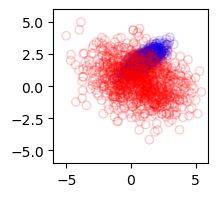

i=1000, loss=1.8321278095245361


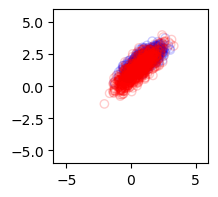

i=2000, loss=1.426425576210022


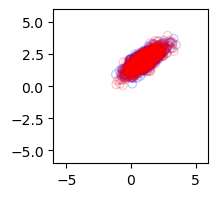

i=3000, loss=1.4257314205169678


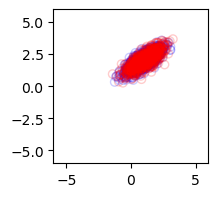

i=4000, loss=1.4257311820983887


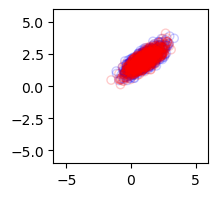

i=5000, loss=1.4257311820983887


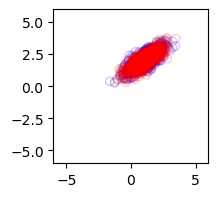

In [7]:
samples = get_samples()

def plot(model):
    samples = get_samples()
    fake = model.generate(1000).detach()
    plt.scatter(samples[:,0],samples[:,1], marker  = 'o', facecolor = 'none', edgecolor = 'b', alpha = 0.2)
    plt.scatter(fake[:,0],fake[:,1], marker = 'o', facecolor = 'none', edgecolor = 'r', alpha = 0.2)
    plt.gcf().set_size_inches(2,2)
    plt.xlim(-6,6)
    plt.ylim(-6,6)
    
def train_flow(model):
    opt = torch.optim.Adam(model.parameters(),1e-3)
    for i in range(5001):
        v1 = model.log_prob(torch.tensor(samples).float())
        loss = -v1.mean()
        loss.backward()
        opt.step()
        opt.zero_grad()
        if i % 1000 == 0:
            print(f"i={i}, loss={float(loss)}")
            plot(model)
            plt.show()

model = MyFlow()
train_flow(model)